In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import os

import numpy as np
import pandas as pd
from PIL import Image

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

pytorch version: 2.1.1
Device: cuda:0


### Data loading

Can be downloaded from https://www.kaggle.com/datasets/jangedoo/utkface-new

In [2]:
images = []
ages = []

DIR = 'data/UTKFace/'
for file_name in os.listdir(DIR)[0:8000]:
    split = file_name.split('_')
    ages.append(int(split[0]))
    images.append(Image.open(DIR + file_name))

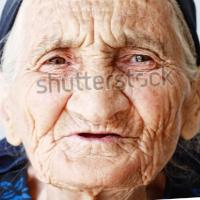

100


In [3]:
display(images[0])
print(ages[0])

In [4]:
images = pd.Series([np.asarray(image.resize((200,200), Image.LANCZOS)).transpose(2,0,1)/255.
                        for image in images], 
                    name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
images[0].shape

(3, 200, 200)

In [5]:
global_df = pd.concat([images, ages], axis=1)
global_df.sample(3)

,Images,Ages
1893,"[[[0.23529411764705882, 0.2549019607843137, 0....",1
3473,"[[[0.15294117647058825, 0.1411764705882353, 0....",27
7185,"[[[0.6509803921568628, 0.6666666666666666, 0.6...",56


In [6]:
data_indices = global_df.index.values
idx_train, idx_test = train_test_split(data_indices, test_size=0.2, random_state=42)
idx_train, idx_valid = train_test_split(idx_train, test_size=0.25, random_state=42)
idx_train.shape, idx_valid.shape, idx_test.shape

((4800,), (1600,), (1600,))

In [7]:
class ImageDataset(Dataset):
    def __init__(self, indices, test=False):
        self.test = test
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if self.test:
            return global_df['Images'][self.indices[idx]]
        else:
            return global_df['Images'][self.indices[idx]], global_df['Ages'][self.indices[idx]]


In [8]:
def collate(batch):
    images = torch.FloatTensor([image for image, target in batch]).to(global_device)
    targets = torch.FloatTensor([target for image, target in batch]).to(global_device)
    return images, targets

def collate_test(batch):
    images = torch.FloatTensor(batch).to(global_device)
    return images

batch_size = 64

dataset_train = ImageDataset(idx_train, test=False)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate)

dataset_val = ImageDataset(idx_valid, test=False)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate)

dataset_test = ImageDataset(idx_test, test=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_test)

### CNN model with pytorch lightning

In [9]:
class RegressionCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Flatten(start_dim=1, end_dim=-1),
                        nn.Linear(25*25*128, 64),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(64, 1),
                    )

        self.loss = nn.MSELoss()
        # self.metric = mean_absolute_error
        
    def forward(self, images):
        outs = self.layers(images)
        return outs

    def training_step(self, batch, batch_idx):
        images, target = batch
        preds = self(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, target = batch
        preds = self(images)
        loss = self.loss(preds, target)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return {"optimizer": optimizer}

In [12]:
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=pl.loggers.CSVLogger(save_dir="logs/"),
                     val_check_interval=0.5, max_epochs=20, log_every_n_steps=15)
model = RegressionCNN()
trainer.validate(model, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             958.7020263671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 958.7020263671875}]

In [13]:
trainer.fit(model, dataloader_train, dataloader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.2 M 
1 | loss   | MSELoss    | 0     
--------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.854    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0:  49%|████▉     | 37/75 [00:46<00:48,  1.27s/it, v_num=0, train_loss=363.0] 

In [ ]:
''' example load trained model from checkpoint '''
# model = RegressionCNN.load_from_checkpoint('lightning_logs/version_28/checkpoints/epoch=19-step=20.ckpt')

### Training process visualisation

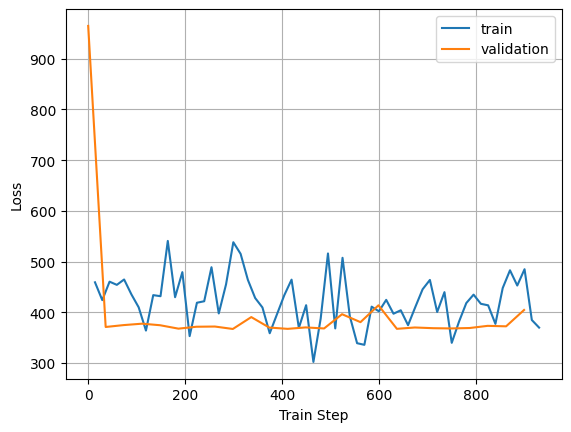

In [104]:
metrics = pd.read_csv('lightning_logs/version_31/metrics.csv')
train_metrics = metrics.dropna(subset=['train_loss'])
val_metrics = metrics.dropna(subset=['val_loss'])
plt.plot(train_metrics['step'], train_metrics['train_loss'], label="train")
plt.plot(val_metrics['step'], val_metrics['val_loss'], label="validation")
plt.xlabel('Train Step')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.yscale('log')

### New images prediction

In [105]:
def predict(model, loader):
    model.to(global_device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in loader:
            preds = model(images)
            predictions.append(preds.cpu().numpy())
    predictions = np.vstack(predictions)
    return predictions

In [106]:
test_pred = predict(model, dataloader_test)
mean_squared_error(global_df["Ages"][idx_test], test_pred)

364.8860107244938

Text(0, 0.5, 'Predicted age')

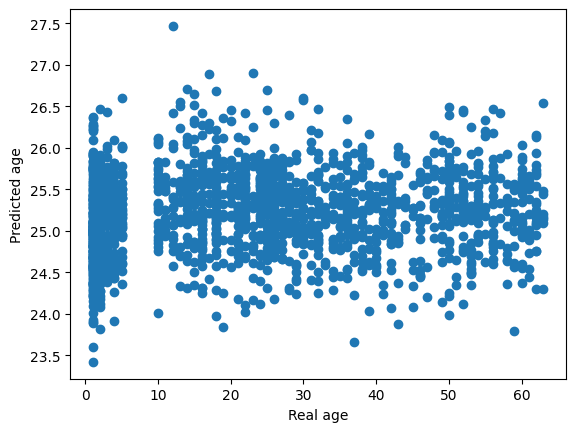

In [111]:
plt.scatter(global_df["Ages"][idx_test], test_pred)
plt.xlabel("Real age")
plt.ylabel("Predicted age")